In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("../input/bike-sharing-demand/train.csv", parse_dates=["datetime"])
df_test = pd.read_csv("../input/bike-sharing-demand/test.csv", parse_dates=["datetime"])

print(df_train.shape)
print(df_test.shape)

(10886, 12)
(6493, 9)


In [3]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["hour"] = df_train["datetime"].dt.hour
df_train["weekday"] = df_train["datetime"].dt.dayofweek

df_train.shape

(10886, 16)

In [4]:
df_test["year"] = df_test["datetime"].dt.year
df_test["month"] = df_test["datetime"].dt.month
df_test["hour"] = df_test["datetime"].dt.hour
df_test["weekday"] = df_test["datetime"].dt.dayofweek

df_test.shape

(6493, 13)

#### 범주형 feature을 category로 변경해주기

In [5]:
categorical_feature_names = ["season", "holiday", "workingday",
                            "weather", "weekday", "year", "hour"]

In [6]:
for var in categorical_feature_names:
    df_train[var] = df_train[var].astype("category")
    df_test[var] = df_test[var].astype("category")

In [7]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "weekday", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'weekday',
 'holiday',
 'workingday']

In [8]:
X_train = df_train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,weekday,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [9]:
X_test = df_test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,weekday,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [10]:
label_name = "count"

y_train = df_train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [11]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):
    
    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
    
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값, 실제값에 +1하고 로그를 씌우기
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # (예측값 - 실제값)의 제곱
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균
    mean_difference = difference.mean()
    
    # 루트
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## 선형 회귀 모델 (Linear Regression Model)

- 예측과 훈련 세트에 있는 타깃y 사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.

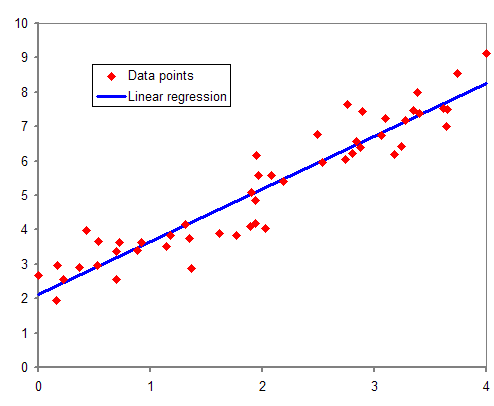

- 파란선: 선형회귀 모델
- 빨간점 : 훈련 데이터

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형 모델 초기화
lModel = LinearRegression()

# 모델 학습
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도 평가
preds = lModel.predict(X_train)
print ("RMSLE Value for Linear Regression: ",
      rmsle(np.exp(y_train_log), np.exp(preds), False))

RMSLE Value for Linear Regression:  0.9803697923313527


## 릿지 (Regularization Model - Ridge)

- 회귀를 위한 선형모델
- 가중치(w)의 모든 원소가 0에 가깝게 만들어, 모든 feature가 주는 영향을 최소화
    - 기울기를 작게 만듬
- 정규화(Regularization)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
- max_iter: 최대 반복 실행하는 횟수

In [13]:
ridge_m_ = Ridge()
ridge_params = {'max_iter': [3000], 
                'alpha': [0.01, 0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_,
                           ridge_params,
                           scoring=rmsle_scorer,
                           cv=5)
y_train_log = np.log1p(y_train)
grid_ridge_m.fit(X_train, y_train_log)
preds = grid_ridge_m.predict(X_train)
print(grid_ridge_m.best_params_)
print("RMSLE Value for Ridge Regression: ", rmsle(np.exp(y_train_log), np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()
      

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value for Ridge Regression:  0.9803697902780836


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014029,0.004274,0.007571,0.002727,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.011846,0.000077,0.006137,0.000051,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.011752,0.000086,0.006190,0.000075,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,3
3,0.011673,0.000114,0.006110,0.000036,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,4
4,0.011651,0.000117,0.006063,0.000027,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987770,0.043460,5


In [14]:
df["alpha"] = df["params"].apply(lambda x: x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x: -x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,1.00,0.987755
3,2.00,0.987762
4,3.00,0.987770


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

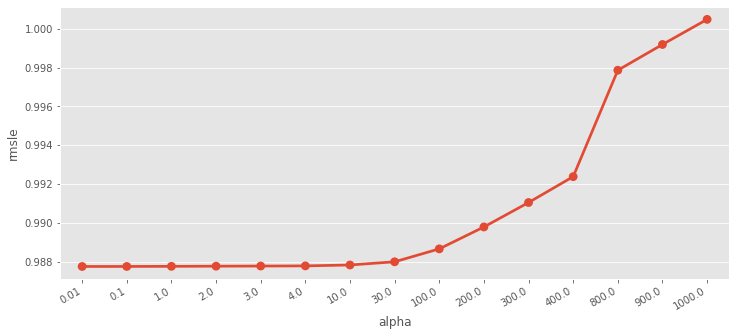

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x="alpha", y="rmsle", ax=ax)

## 라쏘 (Regularization Model - Lasso)

- 선형 회귀의 Regularization(규제)를 적용하는 대안
- 계수를 0에 가깝게 만들려하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데, 이는 완전히 제외하는 피처가 생긴다는 의미
- 피처 선택이 자동으로 이루어진다고 볼 수도 있다.
- alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 함


- 그리드 서치로 아래 라쏘 모델을 실행했을 때 베스트 alpha 값은 0.0025


In [16]:
lasso_m_ = Lasso()

alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params_ = {'max_iter': [3000], 'alpha': alpha}

grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring=rmsle_scorer, cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit(X_train, y_train_log)
preds = grid_lasso_m.predict(X_train)
print(grid_lasso_m.best_params_)
print("RMSLE Value for Lasso Regression: ", rmsle(np.exp(y_train_log), np.exp(preds), False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x: x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x: -x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value for Lasso Regression:  0.980372782145765


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.062110
3,0.333333,1.060815
4,0.250000,1.061139


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

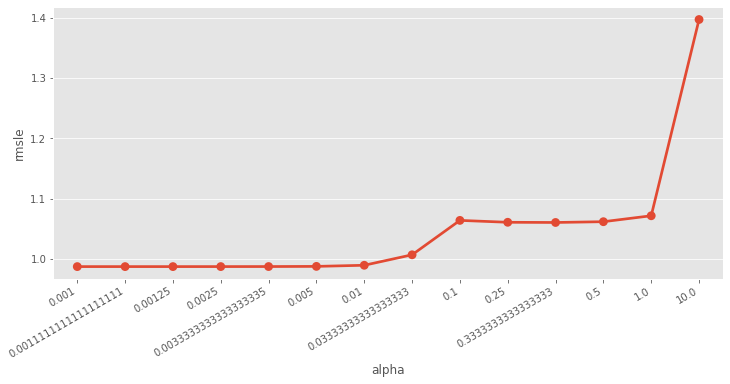

In [17]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## 앙상블 모델 - 랜덤포레스트

### Ensemble Models - Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value for Random Forest: ", score)

RMSLE Value for Random Forest:  0.1071960921101382


## 앙상블 모델 - 그라디언트 부스트

### Ensemble Model - Gradient Boost

- 여러 개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
- 회귀와 분류 모두에 사용할 수 있음
- 랜덤포레스트와 달리 이진트리의 오차를 보완하는 방식으로 순차적으로 트리 만듬
- 무작위성이 없고 강력한 사전 가지치기가 사용됨
- 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름


- learning_rate : 오차를 얼마나 강하게 보정할 것인지 제어
- n_estimator의 값 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 훈련 세트에서의 실수를 바로잡을 기회가 많아지지만 / 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수 있음
- max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value for Gradient Boost: ", score)

RMSLE Value for Gradient Boost:  0.21357403727840335


<AxesSubplot:ylabel='Density'>

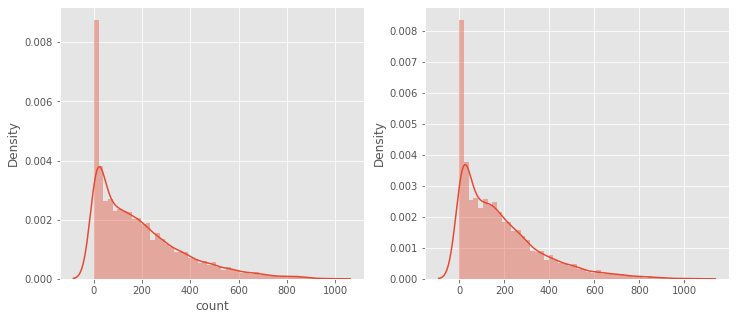

In [20]:
predsTest = gbm.predict(X_test)

fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(12, 5))
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest), ax=ax2,bins=50)

# Submit

In [21]:
submission = pd.read_csv("../input/bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918


In [22]:
submission.to_csv(f"Score_{score:.5f}_submission.csv", index=False)